Installing the Spark Dependancies

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz
!tar xf spark-3.0.3-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark==3.0.3

     |████████████████████████████████| 209.1 MB 55 kB/s 
     |████████████████████████████████| 198 kB 18.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.3-py2.py3-none-any.whl size=209435970 sha256=1762cf359b4a80110b6a60c42c89c5f1890b73433e78d83b7fa301eb847d21f5
  Stored in directory: /root/.cache/pip/wheels/7e/6d/0a/6b0bf301bc056d9af03194b732b9f49ad2fceb205aab2984fd
Successfully built pyspark


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"

Downloading data

In [3]:
! wget https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv

--2021-12-01 23:08:28--  https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81872115 (78M) [text/plain]
Saving to: ‘us-counties.csv’

us-counties.csv     100%[===================>]  78.08M   187MB/s    in 0.4s    

2021-12-01 23:08:29 (187 MB/s) - ‘us-counties.csv’ saved [81872115/81872115]



**Start your program**

In [4]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession

Create a Spark Session

In [5]:
conf = SparkConf().set('spark.ui.port', '4050')
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()

Read the dataset as a Dataframe

In [6]:
# Load the dataset
data = spark.read.load('/content/us-counties.csv', format='csv', inferSchema=True, header=True)

# Print schema
data.printSchema()

root
 |-- date: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- fips: integer (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)



In [7]:
# See first 10 rows of the dataset
data.head(10)

[Row(date='2020-01-21', county='Snohomish', state='Washington', fips=53061, cases=1, deaths=0),
 Row(date='2020-01-22', county='Snohomish', state='Washington', fips=53061, cases=1, deaths=0),
 Row(date='2020-01-23', county='Snohomish', state='Washington', fips=53061, cases=1, deaths=0),
 Row(date='2020-01-24', county='Cook', state='Illinois', fips=17031, cases=1, deaths=0),
 Row(date='2020-01-24', county='Snohomish', state='Washington', fips=53061, cases=1, deaths=0),
 Row(date='2020-01-25', county='Orange', state='California', fips=6059, cases=1, deaths=0),
 Row(date='2020-01-25', county='Cook', state='Illinois', fips=17031, cases=1, deaths=0),
 Row(date='2020-01-25', county='Snohomish', state='Washington', fips=53061, cases=1, deaths=0),
 Row(date='2020-01-26', county='Maricopa', state='Arizona', fips=4013, cases=1, deaths=0),
 Row(date='2020-01-26', county='Los Angeles', state='California', fips=6037, cases=1, deaths=0)]

**Task 0. Find the daily new cases across the entire US and plot**
(*you DO not need to do this, this code is given for your assistance*)

+----------+-----------+
|      date|total_cases|
+----------+-----------+
|2020-01-21|          1|
|2020-01-22|          1|
|2020-01-23|          1|
|2020-01-24|          2|
|2020-01-25|          3|
|2020-01-26|          5|
|2020-01-27|          5|
|2020-01-28|          5|
|2020-01-29|          5|
|2020-01-30|          6|
+----------+-----------+
only showing top 10 rows



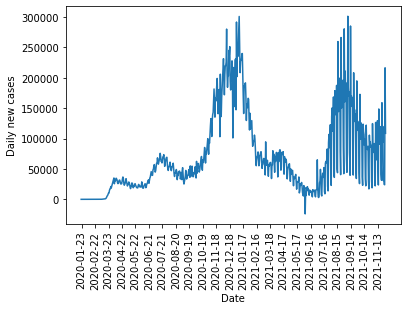

In [8]:
from pyspark.sql import functions as F

# Aggregate by day, sum the cases for all counties for each day
daily_cumulative = data.groupby('date').agg(F.sum('cases').alias('total_cases'))
daily_cumulative = daily_cumulative.sort('date')
daily_cumulative.show(10)

# Convert Spark dataframe to a Panda dataframe to plot
plot_data = daily_cumulative.toPandas()
dates = plot_data['date']
values = plot_data['total_cases']

# Find daily news cases from cumulative cases
daily_cases = [values[i+1] - values[i] for i in range(len(values)-1)]
ddates = [dates[i+1] for i in range(len(values)-1)]

import matplotlib.pyplot as plt
import numpy as np
plt.plot(ddates, daily_cases)
plt.xlabel('Date')
plt.ylabel('Daily new cases')
plt.xticks(np.arange(1, len(daily_cases),30), [ddates[i] for i in np.arange(1, len(daily_cases),30)], rotation=90)
plt.show()

**Task 1: Find the total number of new cases added in the entire US in the  month of March 2020.**

In [9]:
#Importing libraries
from pyspark.sql.functions import to_timestamp,date_format
from pyspark.sql.functions import *
        
#converting date from string format to date format
data1 = data.withColumn('date', to_date(data.date, 'yyyy-MM-dd')) 
        
#Creating separate columns for year and month
data2= data1.withColumn('year',year(data1.date))
data2 = data2.withColumn('month',month(data1.date))
data2.show(5)
data2.printSchema()
        
#Displaying Total no of cases in the month of March 2020
data3 = data2.filter(data2.year == '2020')
data2_cases = data3.filter(data3.month == '3')
data2_cases.show(10)
data2_cases.agg({'cases': 'sum'}).show()

+----------+---------+----------+-----+-----+------+----+-----+
|      date|   county|     state| fips|cases|deaths|year|month|
+----------+---------+----------+-----+-----+------+----+-----+
|2020-01-21|Snohomish|Washington|53061|    1|     0|2020|    1|
|2020-01-22|Snohomish|Washington|53061|    1|     0|2020|    1|
|2020-01-23|Snohomish|Washington|53061|    1|     0|2020|    1|
|2020-01-24|     Cook|  Illinois|17031|    1|     0|2020|    1|
|2020-01-24|Snohomish|Washington|53061|    1|     0|2020|    1|
+----------+---------+----------+-----+-----+------+----+-----+
only showing top 5 rows

root
 |-- date: date (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- fips: integer (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)

+----------+-------------+----------+----+-----+------+----+-----+
|      date|       county|  

**Task 2: Calculate the total new cases added in three consecutive months of June, July, and August of 2020 in Jackson county, Missouri (fips code 29095).**

In [22]:

data3 = data2.filter(data2.fips == '29095')
data2_yr = data3.filter(data3.year == '2020')
data2_mo = data2_yr[data2_yr['month'].between(6, 8)]
data2_mo.show()
data2_mo.agg({'cases': 'sum'}).show()


+----------+-------+--------+-----+-----+------+----+-----+
|      date| county|   state| fips|cases|deaths|year|month|
+----------+-------+--------+-----+-----+------+----+-----+
|2020-06-01|Jackson|Missouri|29095|  613|    19|2020|    6|
|2020-06-02|Jackson|Missouri|29095|  637|    22|2020|    6|
|2020-06-03|Jackson|Missouri|29095|  656|    22|2020|    6|
|2020-06-04|Jackson|Missouri|29095|  676|    22|2020|    6|
|2020-06-05|Jackson|Missouri|29095|  686|    22|2020|    6|
|2020-06-06|Jackson|Missouri|29095|  696|    22|2020|    6|
|2020-06-07|Jackson|Missouri|29095|  702|    22|2020|    6|
|2020-06-08|Jackson|Missouri|29095|  716|    22|2020|    6|
|2020-06-09|Jackson|Missouri|29095|  727|    22|2020|    6|
|2020-06-10|Jackson|Missouri|29095|  752|    22|2020|    6|
|2020-06-11|Jackson|Missouri|29095|  782|    22|2020|    6|
|2020-06-12|Jackson|Missouri|29095|  791|    22|2020|    6|
|2020-06-13|Jackson|Missouri|29095|  819|    22|2020|    6|
|2020-06-14|Jackson|Missouri|29095|  819

**Task 3: Find the daily new cases per month per 1000 population in Missouri state (MO) since the beginning of the pandemic (assume MO's population is 6,154,913). [Plot the data]**

**Task 4:  On which date all 50 US states have at least 100 cases? At least one death?**

In [29]:
data2_case = data2.filter(data2.cases >= 100)
data2_case1 = data2_case.filter(data2.deaths >=1)
data2_case1.show(20)

+----------+-------------+----------+-----+-----+------+----+-----+
|      date|       county|     state| fips|cases|deaths|year|month|
+----------+-------------+----------+-----+-----+------+----+-----+
|2020-03-09|         King|Washington|53033|  117|    21|2020|    3|
|2020-03-10|         King|Washington|53033|  191|    23|2020|    3|
|2020-03-11|         King|Washington|53033|  235|    27|2020|    3|
|2020-03-12|         King|Washington|53033|  271|    28|2020|    3|
|2020-03-12|    Snohomish|Washington|53061|  107|     3|2020|    3|
|2020-03-13|         King|Washington|53033|  329|    33|2020|    3|
|2020-03-13|    Snohomish|Washington|53061|  132|     3|2020|    3|
|2020-03-14|New York City|  New York| null|  269|     1|2020|    3|
|2020-03-14|         King|Washington|53033|  389|    36|2020|    3|
|2020-03-14|    Snohomish|Washington|53061|  154|     3|2020|    3|
|2020-03-15|  Santa Clara|California| 6085|  114|     2|2020|    3|
|2020-03-15|New York City|  New York| null|  330

**Task 5: Which single day in the year 2020 had the largest number of deaths in the entire US (if there are multiple such dates, choose the earliest one)?**

In [27]:
data3 = data2.filter(data2.year == '2020')
data3.sort(desc('deaths')).show(1)

+----------+-------------+--------+----+------+------+----+-----+
|      date|       county|   state|fips| cases|deaths|year|month|
+----------+-------------+--------+----+------+------+----+-----+
|2020-12-31|New York City|New York|null|430863| 25144|2020|   12|
+----------+-------------+--------+----+------+------+----+-----+
only showing top 1 row

